<a href="https://colab.research.google.com/github/GrueneKatze/GANs/blob/main/Face_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [ ]:
import zipfile

In [ ]:
with zipfile.ZipFile('/content/gdrive/MyDrive/Celeba/img_align_celeba.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/gdrive/MyDrive/Celeba/cel')

In [2]:
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
from PIL import Image
from matplotlib import pyplot as plt

In [ ]:
#4

100%|██████████| 10000/10000 [44:19<00:00,  3.76it/s]


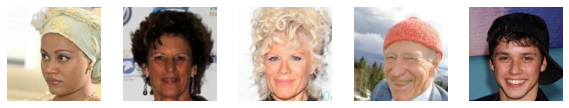

In [6]:

#

PIC_DIR = '/content/gdrive/MyDrive/Celeba/cel/img_align_celeba/'
#r'C:\Users\Tanya\Desktop\img_align_celeba'#r'C:\Users\Tanya\Desktop\GAN_Celeba\img_align_celeba'
#r'C:\Users\Tanya\Desktop\GAN_Celeba\img_align_celeba'#r'C:\Users\Tanya\Desktop\GAN_Celeba\img_align_celeba/'
IMAGES_COUNT = 10000
ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2
WIDTH = 128
HEIGHT = 128
crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)
images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic)) #Normalize the images
images = np.array(images) / 255
images.shape #print first 25 images
plt.figure(1, figsize=(10, 10))
for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [7]:
#https://github.com/nageshsinghc4/Face-generation-GAN/blob/master/face_GAN.ipynb
LATENT_DIM = 32
CHANNELS = 3
def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))
    
    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)
    
    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)
    
    generator = Model(gen_input, x)
    return generator

In [8]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))
    
    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)
    
    optimizer = RMSprop(
        learning_rate=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
    
    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )
    
    return discriminator


In [9]:
generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False


In [10]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)#Adversarial Model
optimizer = RMSprop(learning_rate=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [ ]:
import time
iters = 20000
batch_size = 16
RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)
CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2
start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)
    
    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])
    
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)
    
    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)
    
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)
    
    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0
    
    if step % 50 == 49:
        gan.save_weights('gan.h5')
        
        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))
        
        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses)
plt.xlabel('Epochs')
plt.ylabel('Discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('Epochs')
plt.ylabel('Adversary losses')
plt.show()

50/20000: d_loss: 0.5941,  a_loss: 0.6583.  (2.1 sec)
100/20000: d_loss: 0.6410,  a_loss: 0.9925.  (2.1 sec)
150/20000: d_loss: 0.6371,  a_loss: 1.1850.  (2.1 sec)
200/20000: d_loss: 0.6918,  a_loss: 0.9125.  (2.1 sec)
250/20000: d_loss: 0.6639,  a_loss: 0.8340.  (2.3 sec)
300/20000: d_loss: 0.7085,  a_loss: 0.9613.  (2.1 sec)
350/20000: d_loss: 0.6514,  a_loss: 0.9717.  (2.3 sec)
400/20000: d_loss: 0.6279,  a_loss: 0.8404.  (2.1 sec)
450/20000: d_loss: 0.7199,  a_loss: 1.0797.  (2.1 sec)
500/20000: d_loss: 0.5959,  a_loss: 0.9533.  (2.0 sec)
550/20000: d_loss: 0.6660,  a_loss: 1.0960.  (2.1 sec)
600/20000: d_loss: 0.6903,  a_loss: 0.7994.  (2.1 sec)
650/20000: d_loss: 0.6684,  a_loss: 0.9260.  (2.1 sec)
700/20000: d_loss: 0.6618,  a_loss: 0.9194.  (2.1 sec)
750/20000: d_loss: 0.5878,  a_loss: 0.8931.  (2.1 sec)
800/20000: d_loss: 0.6678,  a_loss: 1.0603.  (2.1 sec)
850/20000: d_loss: 0.6800,  a_loss: 1.1462.  (2.1 sec)
900/20000: d_loss: 0.6780,  a_loss: 1.2254.  (2.1 sec)
950/20000: 

In [ ]:
import imageio
import shutil
images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('trainnig_visual.gif', images_to_gif)
shutil.rmtree(RES_DIR)